## CS579 Project II LSTM Model Road Map

Author: Christopher Hong

* Step 1: Setting up working environment
* Step 2: Preparing data
  * Step 2.1: Loading data
  * Step 2.2: Partitioning data
  * Step 2.3: Wrangling data
  * Step 2.4: Engineering feature
* Step 3: Training supervised data
  * Step 3.1 Defining model architecture
  * Step 3.2 Training model with early stopping
  * Step 3.3 Assessing held-out performance
* Step 4: Predicting test data

<a id='s1'></a>
## 1 Setting up working environment

**Note**: After importing libraries, please go to `1.2` to setup proper file directories.

<a id='1.1'></a>
### 1.1 Importing libraries

In [ ]:
# Common library
import tensorflow as tf
import pandas as pd
import numpy as np
import os

# Text processing packages
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Machine Learning packages
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score

# Visualization packages
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=16)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

# Aesthetic setting
import warnings
warnings.filterwarnings('ignore')

# Reproducibility setting
np.random.seed(2020)
tf.random.set_seed(2020)
random_state = 2020

# Path to local Google Drive
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Mounted at /content/drive


<a id='1.2'></a>
### 1.2 Setting file path to Google Drive

**Note**: Please setup proper path to Google Drive before testing.
Assuming `train, test, sample submission .csv files` are in `/content/drive/MyDrive/CS579_Project_2/option1-data`.

In [ ]:
# Define the base dir to local Google Drive
BASE_PATH = "/content/drive/MyDrive/CS579_Project_2/"

# Define base dir to local drive
DATA_PATH = os.path.join(BASE_PATH, "option1-data")

# Create base dir if not exists
os.makedirs(BASE_PATH, exist_ok=True)
os.makedirs(DATA_PATH, exist_ok=True)

# Define the path to the train, test and submission data
TRAIN_DATA_PATH = os.path.join(DATA_PATH, "train.csv")
TEST_DATA_PATH = os.path.join(DATA_PATH, "test.csv")
SUB_DATA_PATH = os.path.join(DATA_PATH, 'sample_submission.csv')
print("train data path:", TRAIN_DATA_PATH)
print("test data path:", TEST_DATA_PATH)
print("submission data path:", SUB_DATA_PATH)

train data path: /content/drive/MyDrive/CS579_Project_2/option1-data/train.csv
test data path: /content/drive/MyDrive/CS579_Project_2/option1-data/test.csv
submission data path: /content/drive/MyDrive/CS579_Project_2/option1-data/sample_submission.csv


<a id='s2'></a>
## 2 Preparing data

<a id='2.1'></a>
### 2.1 Loading data

In [ ]:
# Load train data
df_train = pd.read_csv(TRAIN_DATA_PATH)

# Load test data
df_test = pd.read_csv(TEST_DATA_PATH)

# Load submission data
df_sub = pd.read_csv(SUB_DATA_PATH)

# Data quality check
df_train.shape, df_test.shape, df_sub.shape

((256442, 6), (64110, 5), (64110, 2))

<a id='2.2'></a>
### 2.2 Partitioning data

In [ ]:
# Split the train data into 75/25 train and validation set
test_size= 0.25

# Stratified random sampling
split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
for train_index, val_index in split.split(df_train, df_train['label']):
  data_train = df_train.loc[train_index].copy().reset_index(drop=True)
  data_val = df_train.loc[val_index].copy().reset_index(drop=True)

<a id='2.3'></a>
### 2.3 Wrangling data

#### Normalizing text feature

In [ ]:
def normalize(text):
  """
  Lowercase, tokenize, lemmatize, 
  remove stop and unwanted tokens. 
  """
  # Tokenization 
  lower_tokens = word_tokenize(text.lower())

  # Retain alphabetic words
  alpha_tokens = [w for w in lower_tokens if w.isalpha()]

  # Create a lemmatizer object
  wordnet_lemmatizer = WordNetLemmatizer()

  # Lemmatize all tokens
  lemmatized = [wordnet_lemmatizer.lemmatize(w) for w in alpha_tokens]

  # Create a set of stop words
  stop_words = set(stopwords.words('english'))

  # Remove stop words and word length less than 3
  no_stops = [w for w in lemmatized if len(w) > 2 and w not in stop_words]

  return ' '.join(no_stops)

def normalize_sequences(data, normalize=normalize):
  """
  Combine the normalize title 1 & 2 into one column.
  """
  # Normalize title 1 & 2 columns
  data['title1_en_normalized'] = data['title1_en'].map(normalize)
  data['title2_en_normalized'] = data['title2_en'].map(normalize)

  # Combine train normalized title 1 & 2 columns into one column
  data['title_1_2_normalized'] = \
      data['title1_en_normalized'].str.cat(data['title2_en_normalized'], sep=" ")

  return data.drop(columns=['id', 'tid1', 'tid2'], axis=1)

In [ ]:
# Normalize train data
data_train = normalize_sequences(data_train)

# Normalize validation data
data_val = normalize_sequences(data_val)

# Normalize test data
data_test = normalize_sequences(df_test)

<a id='2.4'></a>
### 2.4 Engineering feature

#### Vectorizing text feature

In [ ]:
def create_tokenizer(data, num_words):
  """
  Create a tokenizer with num_words.
  """
  # Create a tokenizer object
  tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words, lower=False)
  # Fit the tokenizer on train text
  tokenizer.fit_on_texts(data['title_1_2_normalized'].values)

  return tokenizer

def vectorize_sequences(data, tokenizer, max_length):
  """
  Vectorize data to sequences and pad with 0 if less than max_length.
  """
  # Transform text to a sequence of integers
  sequence = tokenizer.texts_to_sequences(data['title_1_2_normalized'].values)
  # Pad the sequence with 0
  X = tf.keras.preprocessing.sequence.pad_sequences(sequence, max_length)

  return X

In [ ]:
# Max number of words
num_words = 5000

# Create a tokenizer
tokenizer = create_tokenizer(data_train, num_words)

# Sequece length
max_length = 256

# Vectorize train data
X_train = vectorize_sequences(data_train, tokenizer, max_length)

# Vectorize validation data
X_val = vectorize_sequences(data_val, tokenizer, max_length)

# Vectorize test data
X_test = vectorize_sequences(data_test, tokenizer, max_length)

In [ ]:
# Word to int
obs_int = (X_train[0][np.where(X_train[0])]).tolist()[:10]
obs_word = np.array([None] * len(obs_int))
for idx in range(len(obs_word)):  
    obs_word[idx] = tokenizer.index_word[obs_int[idx]]
pd.DataFrame([obs_int], columns=obs_word.tolist())

,characteristic,let,pregnant,mother,know,difference,boy,baby,girl,share
0,1209,104,47,110,30,1283,84,55,68,347


#### Encoding labels

In [ ]:
def to_one_hot(data, num_classes, lab_2_int):
  """
  Encode labels to one-hot vectors.
  """
  # Transform text labels to integers
  y = data['label'].map(lab_2_int)
  # Encode tegeger labels to one-hot vectors
  y_one_hot = tf.keras.utils.to_categorical(y, num_classes)

  return y, y_one_hot

In [ ]:
# Get target names
target_names = data_train.label.unique().tolist()
print(target_names)

# unrelated -> 0, agreed -> 1, disagreed -> 2
lab_2_int = dict(zip(target_names, range(3)))
print(lab_2_int)

# unrelated <- 0, agreed <- 1, disagreed <- 2
int_2_lab = dict(zip(lab_2_int.values(), lab_2_int.keys()))
print(int_2_lab)

# Encode train label
num_classes = len(target_names)
y_train, y_train_one_hot = to_one_hot(data_train, num_classes, lab_2_int)

# Encode validation label
y_val, y_val_one_hot = to_one_hot(data_val, num_classes, lab_2_int)

['unrelated', 'agreed', 'disagreed']
{'unrelated': 0, 'agreed': 1, 'disagreed': 2}
{0: 'unrelated', 1: 'agreed', 2: 'disagreed'}


In [ ]:
# label
y_train[:5]

0    0
1    1
2    0
3    0
4    0
Name: label, dtype: int64

In [ ]:
 # one-hot label
 print(y_train_one_hot[:5])

[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


<a id='3'></a>
## 3 Training supervised data



<a id='3.1'></a>
### 3.1 Defining model architecture

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 256)          1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               197120    
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 1,477,507
Trainable params: 1,477,507
Non-trainable params: 0
_________________________________________________________________


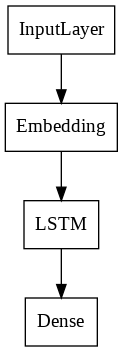

In [ ]:
# Define model params
max_features = num_words
embedding_size = 256
input_length = max_length
lstm_units = 128
num_output = num_classes

# Create a sequential architecture
model = tf.keras.Sequential()
# Add embedding layer
model.add(tf.keras.layers.Embedding(max_features, embedding_size, input_length=input_length))
# Add LSTM layer
model.add(tf.keras.layers.LSTM(lstm_units))
# Add output layer
model.add(tf.keras.layers.Dense(num_output, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model architecture
model.summary()

# Print model digram
tf.keras.utils.plot_model(model, show_layer_names=False)

<a id='3.2'></a>
### 3.2 Training model with early stopping

In [ ]:
# Define stop point iff the validation accuracy stop increasing
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                            mode='max', 
                                            patience=2)
# Train the model
batch_size = 128
epochs = 10
verbose = 1
history = model.fit(X_train, y_train_one_hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_val, y_val_one_hot),
                    callbacks=[callback],
                    verbose=verbose)

Epoch 1/10
1503/1503 [==============================] - 68s 45ms/step - loss: 0.5193 - accuracy: 0.7557 - val_loss: 0.4716 - val_accuracy: 0.7810
Epoch 2/10
1503/1503 [==============================] - 68s 45ms/step - loss: 0.4306 - accuracy: 0.8025 - val_loss: 0.4389 - val_accuracy: 0.7981
Epoch 3/10
1503/1503 [==============================] - 68s 45ms/step - loss: 0.3769 - accuracy: 0.8311 - val_loss: 0.4254 - val_accuracy: 0.8079
Epoch 4/10
1503/1503 [==============================] - 68s 45ms/step - loss: 0.3297 - accuracy: 0.8559 - val_loss: 0.4255 - val_accuracy: 0.8193
Epoch 5/10
1503/1503 [==============================] - 68s 45ms/step - loss: 0.2856 - accuracy: 0.8783 - val_loss: 0.4264 - val_accuracy: 0.8228
Epoch 6/10
1503/1503 [==============================] - 68s 45ms/step - loss: 0.2464 - accuracy: 0.8970 - val_loss: 0.4412 - val_accuracy: 0.8240
Epoch 7/10
1503/1503 [==============================] - 69s 46ms/step - loss: 0.2090 - accuracy: 0.9142 - val_loss: 0.4823 -

<a id='3.3'></a>
### 3.3 Assessing model performance

#### Evaludate held-out performance

In [ ]:
def plot_performance(hist, metric='loss', figsize=(12,8),):
    """
    Plot the model training and validation performance.
    """
    if metric == 'loss':
        ylabel = 'Loss'
        title = 'Training and Validation Loss'
        train_legend = 'Training Loss'
        val_legend = 'Validation Loss'
        train_metric = 'loss'
        val_metric = 'val_loss'
    else:
        ylabel = 'Accuracy'
        title = 'Training and Validation Accuracy'
        train_legend = 'Training Accuracy'
        val_legend = 'Validation Accuracy'
        train_metric = 'accuracy'
        val_metric = 'val_accuracy'
    train = hist.history[train_metric]
    val = hist.history[val_metric]
    epochs = range(1, len(val) + 1)


    plt.figure(figsize=figsize)
    plt.plot(epochs, train, 'bo', label=train_legend)
    plt.plot(epochs, val, 'b', label=val_legend)
    plt.title(title, fontsize=24)
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [ ]:
def calculate_f1(model, X, y):
  """
  Calculate the f1 score on categories of label.
  """
  y_pred = model.predict(X)
  y_pred = [np.argmax(y_hat) for y_hat in y_pred]
  return (f1_score(y, y_pred, average=None)).round(2)

In [ ]:
def compare_performance(df, title, yticks=False):
    """
    Plot bar chart to compare model f1 score performance.
    """
    ax = df.T.plot(kind='bar', rot=0, figsize=(15,10), ylim=(0,100))
    plt.title(title, fontsize=24)
    plt.ylabel("F1-Score (Percentages)")
    if yticks:
      plt.yticks(range(0, 101, 10))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.grid(axis='y')
    plt.legend(fontsize=10)
    plt.show()

In [ ]:
score = calculate_f1(model, X_val, y_val)
print(("Held-out f1 score: " + 
  f"{target_names[0]} = {score[0]} " +
  f"{target_names[1]} = {score[1]} " + 
  f"{target_names[2]} = {score[2]}"))

Held-out f1 score: unrelated = 0.87 agreed = 0.73 disagreed = 0.47


#### Assessing train and validation loss & accuracy

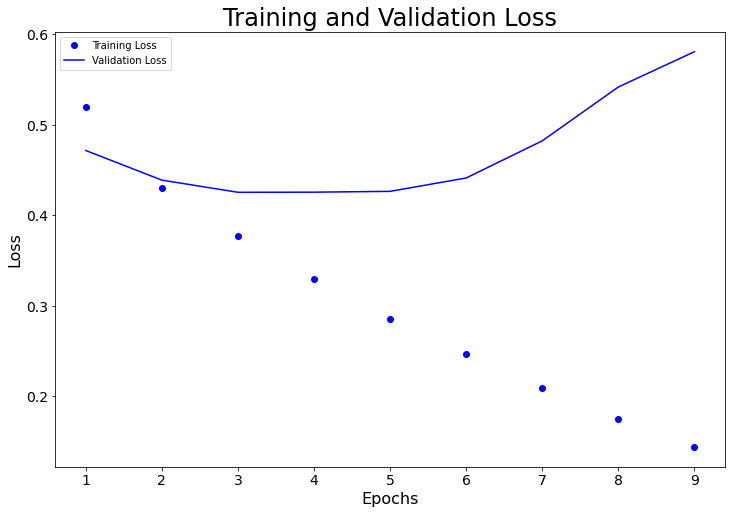

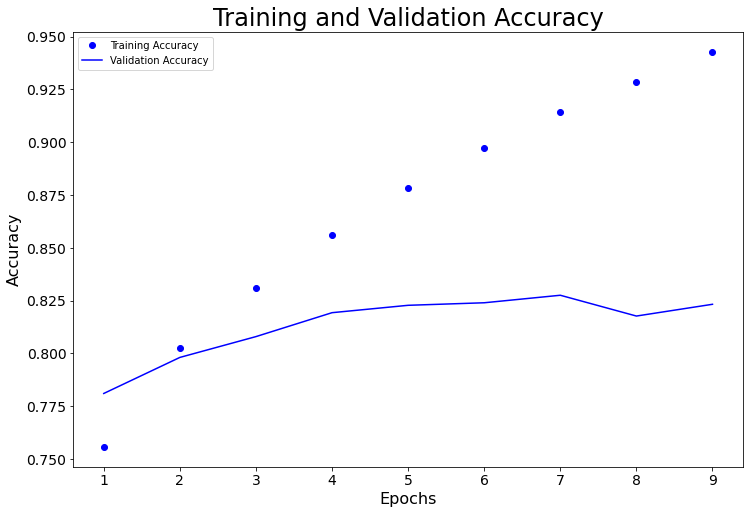

In [ ]:
# Plot the training and validation loss
plot_performance(history)

# Plot the training and validation accuracy
plot_performance(history, 'accuracy')

#### Compare held-out f1-score with train label distribution

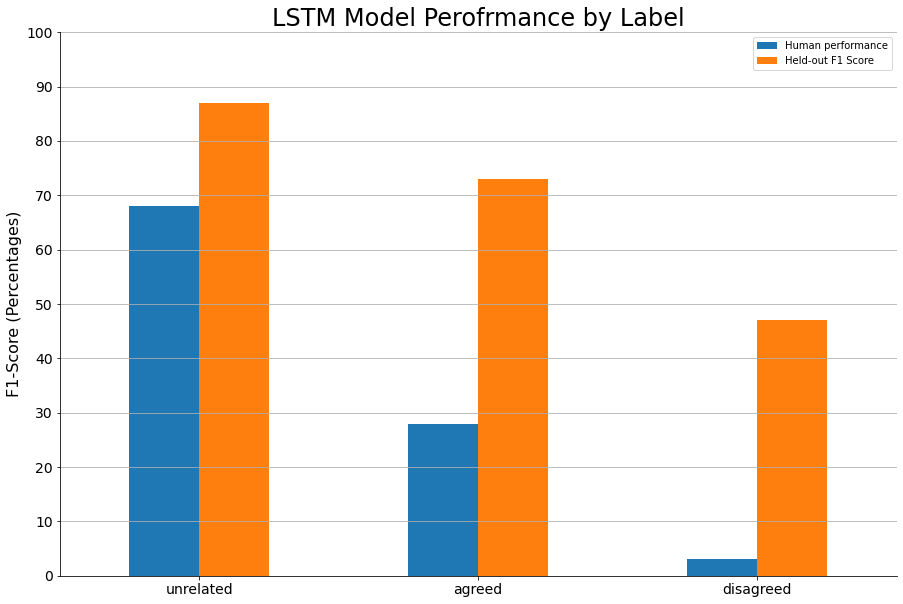

In [ ]:
# Train label distribution
train_label_dist = np.array(df_train.label.value_counts() / df_train.shape[0]).round(2)

# Create a dataframe to store label distribution and validation f1 score
res = pd.DataFrame([train_label_dist * 100, score * 100], 
                   columns=target_names,
                   index=['Human performance',
                          'Held-out F1 Score'])
res = res.astype(int)
compare_performance(res, 'LSTM Model Perofrmance by Label', True)

<a id='3.4'></a>
### 3.4 Incremetally training the model with validation data

In [ ]:
# Stack the train and validation set into one train set
X_train_full = np.vstack((X_train, X_val))
y_train_full = np.vstack((y_train_one_hot, y_val_one_hot))
X_train_full.shape, y_train_full.shape

((256442, 256), (256442, 3))

In [ ]:
# Train the current model with full train set with additinoal 2 epochs
model.fit(X_train_full, y_train_full, epochs=2, batch_size=batch_size, verbose=1)

Epoch 1/2
2004/2004 [==============================] - 83s 41ms/step - loss: 0.2245 - accuracy: 0.9184
Epoch 2/2
2004/2004 [==============================] - 83s 41ms/step - loss: 0.1743 - accuracy: 0.9341


In [ ]:
# Final quality check
score = calculate_f1(model, X_val, y_val)
print(("Held-out f1 score: " + 
  f"{target_names[0]} = {score[0]} " +
  f"{target_names[1]} = {score[1]} " + 
  f"{target_names[2]} = {score[2]}"))
res = model.evaluate(X_val, y_val_one_hot)
print("Held-out loss:", res[0], "accuracy:", res[1])

Held-out f1 score: unrelated = 0.95 agreed = 0.9 disagreed = 0.75
2004/2004 [==============================] - 15s 8ms/step - loss: 0.1858 - accuracy: 0.9299
Held-out loss: 0.18580582737922668 accuracy: 0.9299496412277222


<a id='4'></a>
## 4 Predicting test data

In [ ]:
# Predict test data label
y_pred_test = model.predict(X_test)
y_pred_test = [np.argmax(y_hat) for y_hat in y_pred_test]

In [ ]:
# Store test data labels
df_sub['label_encoded'] = pd.Series(y_pred_test)
df_sub['label'] = df_sub['label_encoded'].map(int_2_lab)
df_sub.sample(10)

,id,label,label_encoded
5458,261900,unrelated,0
52001,308443,unrelated,0
16511,272953,agreed,1
15026,271468,unrelated,0
26315,282757,unrelated,0
39924,296366,unrelated,0
27857,284299,unrelated,0
20175,276617,unrelated,0
48264,304706,agreed,1
37146,293588,unrelated,0


In [ ]:
# Final data quality check
assert sum(df_sub.isnull().sum()) == 0
df_sub['label'].value_counts()

unrelated    44685
agreed       18213
disagreed     1212
Name: label, dtype: int64

In [ ]:
# Save the submission to .csv
df_sub = df_sub.drop(columns=['label_encoded'])
df_sub.to_csv(os.path.join(DATA_PATH, 'submission.csv'), index=False)
df_sub.sample(10)

,id,label
47335,303777,unrelated
47043,303485,unrelated
2475,258917,unrelated
23972,280414,unrelated
60230,316672,unrelated
2137,258579,unrelated
49011,305453,agreed
60702,317144,unrelated
23780,280222,agreed
6803,263245,agreed


In [ ]:
# Save the best model
model.save(os.path.join(DATA_PATH, "final_model.h5"))